In [190]:
import numpy as np
import scipy.sparse as sparse
import math
import matplotlib.pyplot as plt
from matplotlib import cm
from seaborn import heatmap

Use the following: spot price S0 = $100, strike price K = $100, risk-free rate r = 1.8%, level of the
barrier D = $118, maturity T = 0.5 years and α = 0.24 in the local volatility function, to solve the
Black-Scholes PDE numerically to price an up-and-out call option by means on an Explicit finite
difference scheme.

In [191]:
class EuBlackScholesOption:
    def __init__(self, rate, sigma, strike, t_up, x_low, x_up, barrier):
        self.rate = rate
        self.sigma = sigma
        self.strike = strike
        self.t_up = t_up
        self.x_low = x_low
        self.x_up = x_up
        self.D = barrier

    def sigma_calc(self,t,x):
        if self.D is not None:
            return 0.13 * math.exp(-t) * (100 / x) ** self.alpha 
        return self.sigma

    def a(self, t, x):
        if self.D is not None:
            return -self.sigma_calc(t,x)**2*x**2/2
        return -self.sigma**2*x**2/2
    
    def b(self, t, x):
        return -self.rate*x

    def c(self, t, x):
        return self.rate

    def d(self, t, x):
        return 0
    
class EuPutBlackScholes(EuBlackScholesOption):
    def __init__(self, *, rate, sigma, strike, t_up, x_low, x_up, barrier=None):
        super().__init__(rate, sigma, strike, t_up, x_low, x_up, barrier)
        self.type = 'put'

    def bc_tup(self, x):
        return max(self.strike - x, 0)

    def bc_xup(self, t):
        return 0

    def bc_xlow(self, t):
        return math.exp(-self.rate * (self.t_up - t)) * self.strike
    
class EuCallBlackScholes(EuBlackScholesOption):
    def __init__(self, *, rate, sigma, strike, t_up, x_low, x_up, barrier=None, alpha=0.24):
        super().__init__(rate, sigma, strike, t_up, x_low, x_up, barrier)
        self.type = 'call' 
        self.alpha = alpha

    def bc_tup(self, x):
        return max(x - self.strike, 0)

    def bc_xup(self, t):
        return self.x_up - self.strike * math.exp(-self.rate * (self.t_up - t))

    def bc_xlow(self, t):
        return 0
    
class PDESolver:
    """ Base class for all parabolic PDE solvers """
    def __init__(self, pde, imax, jmax):
        self.pde = pde
        self.imax = imax
        self.jmax = jmax
        self.dt = pde.t_up / imax
        self.dx = (pde.x_up - pde.x_low) / jmax
        self.grid = np.empty((imax + 1, jmax + 1))

    def t(self, i):
        return i * self.dt

    def x(self, j):
        return j * self.dx + self.pde.x_low

    def a(self, i, j):
        return self.pde.a(self.t(i), self.x(j))

    def b(self, i, j):
        return self.pde.b(self.t(i), self.x(j))

    def c(self, i, j):
        return self.pde.c(self.t(i), self.x(j))

    def d(self, i, j):
        return self.pde.d(self.t(i), self.x(j))

    def tup(self, i):
        return self.pde.bc_tup(self.x(i))

    def xlow(self, i):
        return self.pde.bc_xlow(self.t(i))

    def xup(self, i):
        return self.pde.bc_xup(self.t(i))

    def interpolate(self, t, x):
        i = int(t / self.dt)
        j = int((x - self.pde.x_low) / self.dx)
        l0 = (t - self.dt * i) / self.dt
        l1 = 1 - l0
        w0 = (x - self.dx * j) / self.dx
        w1 = 1 - w0
        return (self.grid[i,j] * l0 * w0
                + self.grid[i+1,j] * l1 * w0
                + self.grid[i,j+1] * l0 * w1
                + self.grid[i+1,j+1] * l1 * w1)

    def plot_results(self, rx=30, ry=-100):
        S_grid = np.linspace(self.pde.x_low, self.pde.x_up, self.jmax + 1)
        T_grid = np.linspace(0, self.pde.t_up, self.imax + 1)

        V = self.grid

        fig = plt.figure(figsize=(15, 6))

        # Plot Payoff and BS curve
        ax1 = fig.add_subplot(121)
        if self.pde.type == 'call':
            if self.pde.D is not None:
                payoff = [self.pde.bc_tup(s) if self.pde.bc_tup(s) < (self.pde.D - self.pde.strike) else 0 for s in S_grid]
            else:
                payoff = [self.pde.bc_tup(s) for s in S_grid]
        else:
            payoff = [self.pde.bc_tup(s) for s in S_grid]
        ax1.plot(S_grid, payoff, color="blue", label="Payoff")
        ax1.plot(S_grid, V[0, :], color="red", label="BS curve")
        ax1.set_xlim(60, 170)
        ax1.set_ylim(0, 50)
        ax1.set_xlabel("S")
        ax1.set_ylabel("price")
        ax1.legend(loc="upper left")
        ax1.set_title(f"BS price at t=0 ({self.pde.type.capitalize()})")

        # Plot the BS price surface
        X, Y = np.meshgrid(T_grid, S_grid)
        ax2 = fig.add_subplot(122, projection="3d")
        ax2.plot_surface(Y, X, V.T, cmap=cm.ocean)
        ax2.set_title(f"BS price surface ({self.pde.type.capitalize()})")
        ax2.set_xlabel("S")
        ax2.set_ylabel("t")
        ax2.set_zlabel("V")
        ax2.view_init(rx, ry)  # this function rotates the 3d plot

        plt.show()

    def plot_heatmap(self):
        plt.figure(figsize=(10, 8))
        grid_to_plot = np.nan_to_num(self.grid).T  # Replace NaN with zero
        ax = heatmap(grid_to_plot, cmap='viridis', cbar=True)
        ax.invert_yaxis()  # Flip the y-axis
        ax.set_xlabel('i -> t - Time')
        ax.set_ylabel('j -> x - Underlying')
        plt.title("Heatmap of the Grid")
        plt.show()

    
class ExplicitScheme(PDESolver):
    """ Explicit schemd to solve parabolic PDEs """
    def __init__(self, pde, imax, jmax):
        super().__init__(pde, imax, jmax)
        self.solve_grid()
    
    def A(self, i, j):
        return self.dt/self.dx*(self.b(i,j)/2 - self.a(i,j)/self.dx)
    
    def B(self, i, j):
        return 1 - self.dt*self.c(i,j) + 2 * self.dt * self.a(i,j) / self.dx**2

    def C(self, i, j):
        return -self.dt / self.dx * (self.b(i,j) / 2 + self.a(i,j) / self.dx)

    def D(self, i, j):
        return -self.dt * self.d(i,j)

    def solve_grid(self):
        def grid(i, j):
            return self.A(i,j) * self.grid[i,j-1] + self.B(i,j) * self.grid[i,j] + self.C(i,j) * self.grid[i,j+1] + self.D(i,j)
        
        self.grid[self.imax, :] = [self.tup(j) for j in range(self.jmax+1)]
        for i in range(self.imax, 0, -1):
            self.grid[i-1, 0] = self.xlow(i-1)
            self.grid[i, self.jmax] = self.xup(i-1)
            self.grid[i-1, 1:-1] = [grid(i,j) for j in range(1, self.jmax)]
    
class ImplicitScheme(PDESolver):
    """ Explicit schemd to solve parabolic PDEs """
    def __init__(self, pde, imax, jmax):
        super().__init__(pde, imax, jmax)
        self.solve_grid()
    
    def A(self, i, j):
        return 0
    
    def B(self, i, j):
        return 1

    def C(self, i, j):
        return 0

    def D(self, i, j):
        return -self.dt * self.d(i-1, j)

    def E(self, i, j):
        return -self.dt / self.dx * (self.b(i-1, j) / 2 - self.a(i - 1, j) / self.dx)

    def F(self, i, j):
        return 1 + self.dt * self.c(i-1, j) - 2 * self.dt * self.a(i-1, j) / self.dx**2

    def G(self, i, j):
        return self.dt / self.dx * (self.b(i-1, j) / 2 + self.a(i-1, j) / self.dx)

    def w(self, i):
        return [self.D(i,1) + self.A(i,1) * self.xlow(i) - self.E(i,1) * self.xlow(i-1)] \
            + [self.D(i,k) for k in range(2, self.jmax - 1)] + [self.D(i,self.jmax-1) \
            + self.C(i, self.jmax-1) * self.xup(i) - self.G(i, self.jmax-1) * self.xup(i-1)]

    def compute_vi(self, i):
        A1 = [self.A(i,j) for j in range(2,self.jmax)]
        Ad = [self.B(i,j) for j in range(1, self.jmax)]
        Ar = [self.C(i,j) for j in range(1, self.jmax-1)]
        A = sparse.diags([A1, Ad, Ar], [-1, 0, 1])
        B1 = [self.E(i,j) for j in range(2, self.jmax)]
        Bd = [self.F(i,j) for j in range(1,self.jmax)]
        Br = [self.G(i,j) for j in range(1, self.jmax-1)]
        B = sparse.diags([B1, Bd, Br], [-1, 0, 1])
        rhs = A @ self.grid[i,1:-1] + self.w(i)
        return sparse.linalg.splu(B).solve(rhs)

    def solve_grid(self):
        self.grid[self.imax, :] = [self.tup(j) for j in range(self.jmax+1)]
        for i in range(self.imax, -1, -1):
            self.grid[i-1, 0] = self.xlow(i-1)
            self.grid[i, self.jmax] = self.xup(i-1)
            self.grid[i-1, 1:-1] = self.compute_vi(i)

In [192]:
# Put-Call Parity Test
rate=0.05
sigma=0.2
strike=100
t_up=1/12
x_low=0
x_up=200
imax = 100
jmax = 100
S = 100  # Current stock price

# Create instances of put and call solvers
put_pde = EuPutBlackScholes(rate=rate, sigma=sigma, strike=strike, t_up=t_up, x_low=x_low, x_up=x_up)
call_pde = EuCallBlackScholes(rate=rate, sigma=sigma, strike=strike, t_up=t_up, x_low=x_low, x_up=x_up)

put_solver = ExplicitScheme(put_pde, imax, jmax)
call_solver = ExplicitScheme(call_pde, imax, jmax)

# Interpolate to find the option prices at S
put_price = put_solver.interpolate(0, S)
call_price = call_solver.interpolate(0, S)

# Calculate the expected put-call parity value
expected_value = S - strike * math.exp(-rate * t_up)

# Print the results
print(f"Put Price: {put_price:.2f}")
print(f"Call Price: {call_price:.2f}")
print(f"Put-Call Parity Difference: {(call_price - put_price - expected_value):.2f}")

Put Price: 1.27
Call Price: 3.68
Put-Call Parity Difference: 2.00


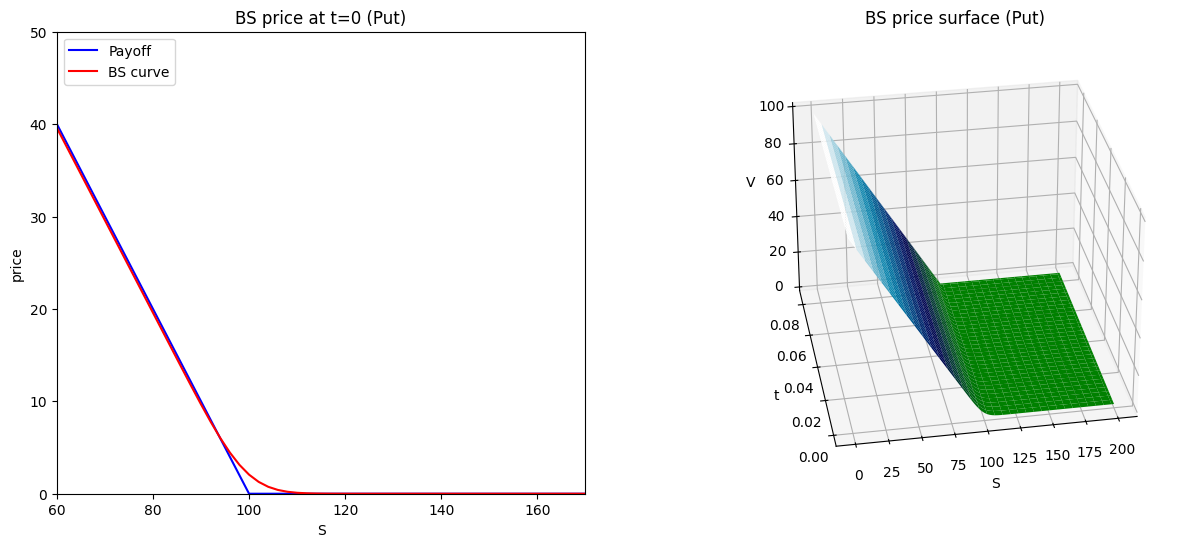

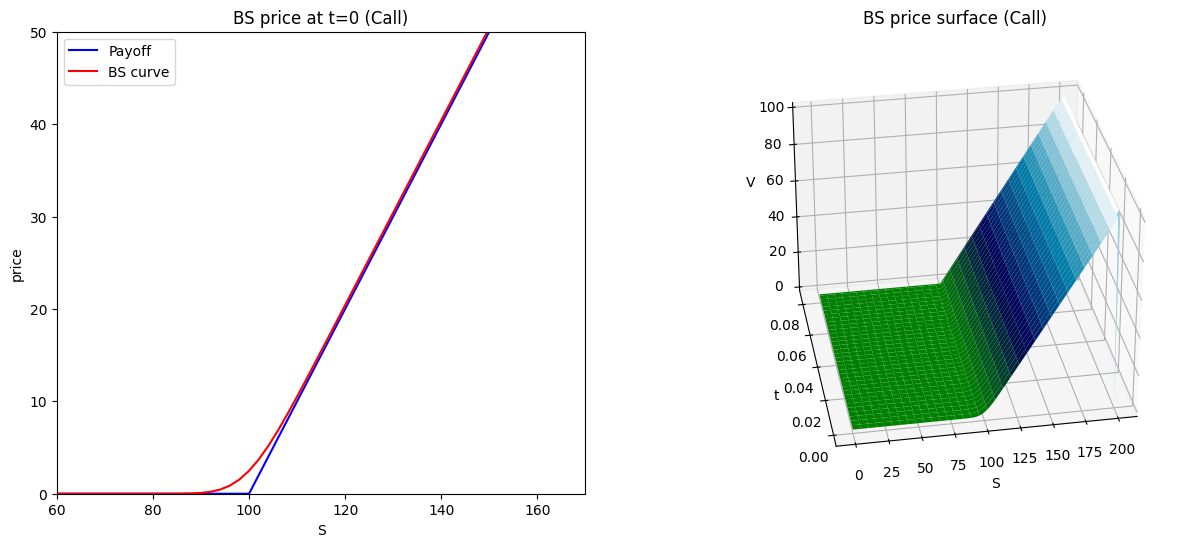

In [193]:
put_solver.plot_results()
call_solver.plot_results()

In [194]:
implicit_put_solver = ImplicitScheme(put_pde, imax, jmax)
implicit_call_solver = ImplicitScheme(call_pde, imax, jmax)

# Interpolate to find the option prices at S
implicit_put_price = implicit_put_solver.interpolate(0, S)
implicit_call_price = implicit_call_solver.interpolate(0, S)

# Calculate the expected put-call parity value
expected_value = S - strike * math.exp(-rate * t_up)

# Print the results
print(f"Put Price: {put_price:.2f}")
print(f"Call Price: {call_price:.2f}")
print(f"Put-Call Parity Difference: {(implicit_call_price - implicit_put_price - expected_value):.2f}")

Put Price: 1.27
Call Price: 3.68
Put-Call Parity Difference: 2.00


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)


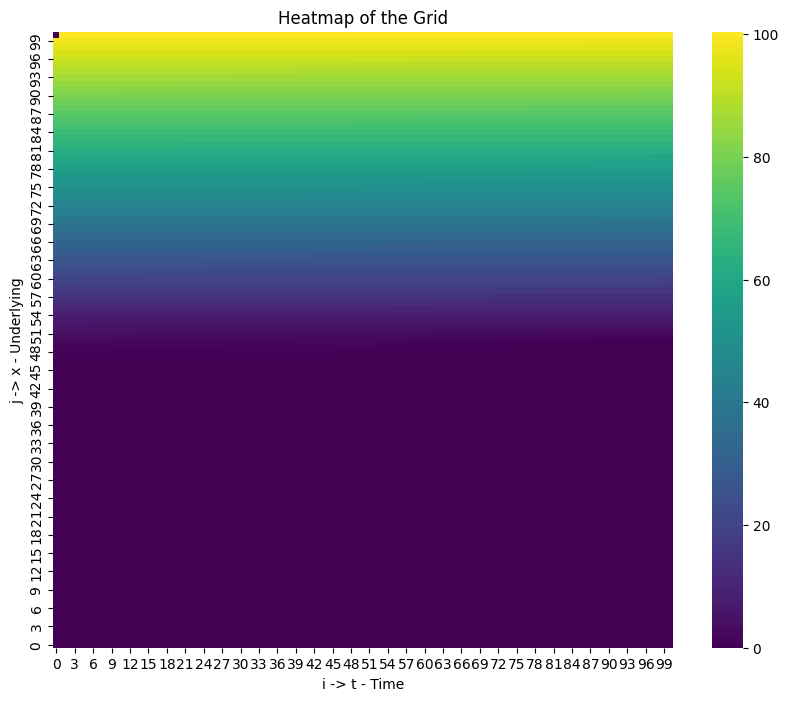

In [195]:
call_solver.plot_heatmap()

Trying to implement the barrier condition: self.pde.D

In [196]:
class ExplicitBarrierScheme(PDESolver):
    """ Explicit scheme to solve parabolic PDEs with barrier options """
    def __init__(self, pde, imax, jmax):
        super().__init__(pde, imax, jmax)
        self.solve_grid()
    
    def A(self, i, j):
        return self.dt/self.dx * (self.b(i, j) / 2 - self.a(i, j) / self.dx)
    
    def B(self, i, j):
        return 1 - self.dt * self.c(i, j) + 2 * self.dt * self.a(i, j) / self.dx**2

    def C(self, i, j):
        return -self.dt / self.dx * (self.b(i, j) / 2 + self.a(i, j) / self.dx)

    def D(self, i, j):
        return -self.dt * self.d(i, j)

    def solve_grid(self):
        def grid(i, j):
            return (self.A(i, j) * self.grid[i, j-1] + 
                    self.B(i, j) * self.grid[i, j] + 
                    self.C(i, j) * self.grid[i, j+1] + 
                    self.D(i, j))
        
        # Initialize grid at maturity
        self.grid[self.imax, :] = [self.tup(j) for j in range(self.jmax+1)]

        # Apply the barrier condition at maturity
        for j in range(self.jmax+1):
            if self.x(j) >= self.pde.D:
                self.grid[self.imax, j] = 0

        # Iterate backward in time
        for i in range(self.imax, 0, -1):
            self.grid[i-1, 0] = self.xlow(i-1)
            self.grid[i-1, -1] = self.xup(i-1)
            for j in range(1, self.jmax):
                self.grid[i-1, j] = grid(i, j)
                # Apply the barrier condition at each time step
                if self.x(j) >= self.pde.D:
                    self.grid[i-1, j] = 0

Barrier Call Price: 3.65


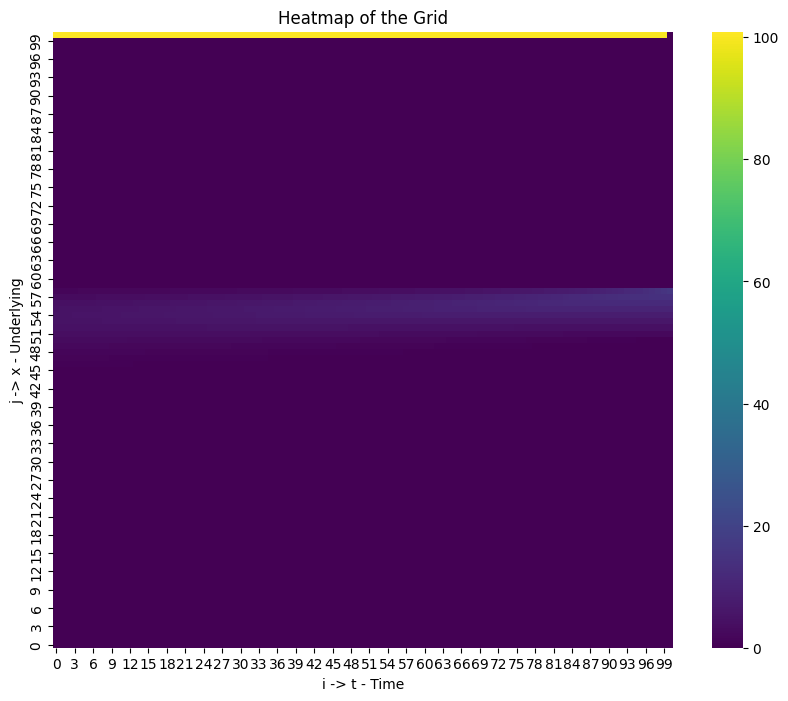

In [197]:
rate=0.018
sigma=0.24
strike=100
t_up=1/2
x_low=0
x_up=200
barrier=118
imax = 100
jmax = 100
S = 100  # Current stock price

# Create instances of put and call solvers
barrier_pde = EuCallBlackScholes(rate=rate, sigma=sigma, strike=strike, t_up=t_up, x_low=x_low, x_up=x_up, barrier=barrier)

solver2 = ExplicitBarrierScheme(barrier_pde, imax, jmax)

# Interpolate to find the option prices at S
price = solver2.interpolate(0, S)

# Print the results
print(f"Barrier Call Price: {price:.2f}")

solver2.plot_heatmap()

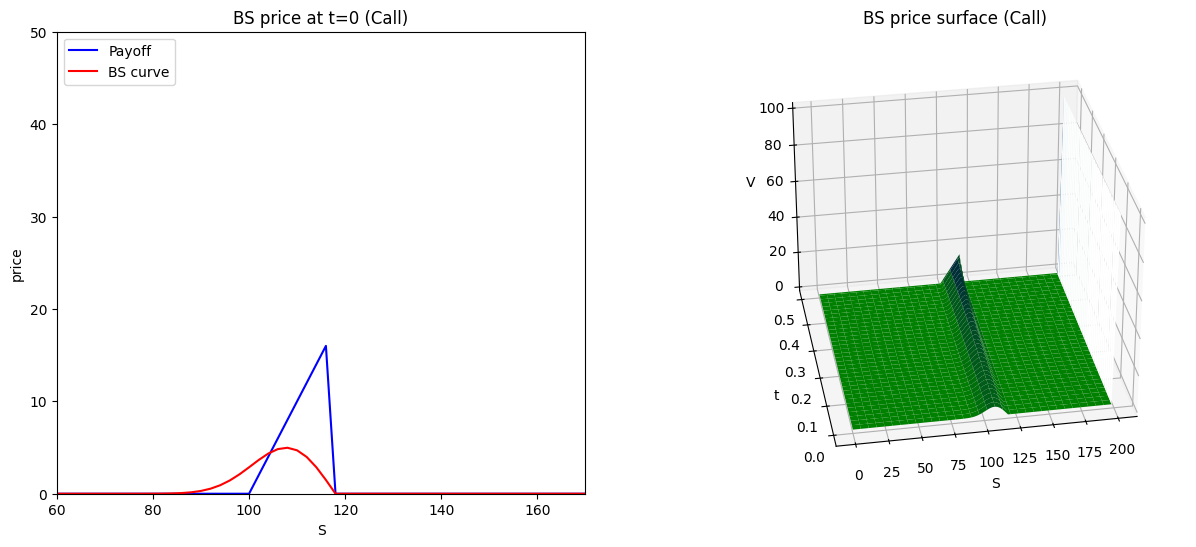

In [198]:
solver2.plot_results()